# Region growing for image segmentation

In [1]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
        ax.set_title(label)
     
    
def print_images(images, nrows=1, ncols=1, titles=None):
    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
        ax.set_title(label)
        
        
#function for computing the gradient magnitude using the sobel operator from openCV
def gradient_magnitude(img):    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    return gradient_magnitude


#function for obtaining a binary map based on the gradient magnitude
def threshold_gradient_magnitude(gradient_magnitude, threshold):
    binary_map = np.zeros(gradient_magnitude.shape, dtype=np.uint8)
    binary_map[gradient_magnitude >= threshold] = 255
    return binary_map


#function that assign a unique label to each connected component.
def find_connected_components(binary_map):
    height, width = binary_map.shape
    labels = np.zeros((height, width), dtype=np.int32)
    label = 1
    for i in range(height):
        for j in range(width):
            if binary_map[i, j] == 255 and labels[i, j] == 0:
                labels = flood_fill(binary_map, labels, i, j, label)
                label += 1
    return labels

def flood_fill(binary_map, labels, row, col, label):
    if binary_map[row, col] == 255 and labels[row, col] == 0:
        labels[row, col] = label
        for i, j in [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]:
            if i >= 0 and i < binary_map.shape[0] and j >= 0 and j < binary_map.shape[1]:
                labels = flood_fill(binary_map, labels, i, j, label)
    return labels


#function for computing the centroids for each connected component
def calculate_centroid(labels):
    height, width = labels.shape
    centroids = []
    for label in np.unique(labels):
        if label == 0:
            continue
        row_sum = 0
        col_sum = 0
        count = 0
        for i in range(height):
            for j in range(width):
                if labels[i, j] == label:
                    row_sum += i
                    col_sum += j
                    count += 1
        centroids.append((row_sum / count, col_sum / count))
    return centroids


#function for selecting centroids of minimum gradient areas
def select_components(centroids, gradient_magnitude, threshold):
    selected_pixels = []
    for row, col in centroids:
        if gradient_magnitude[int(row), int(col)] < threshold:
            selected_pixels.append((int(row), int(col)))
    return selected_pixels


#region growing algorithm
def region_growing(image, seeds, threshold):
    rows = [1,0,-1,0]
    cols = [0,1,0,-1]
    pixels = seeds.copy()
    height, width = image.shape
    segmented_image = np.zeros(image.shape, dtype=np.uint8)
    while pixels:
        pixel = pixels.pop()
        row, col = pixel
        if segmented_image[row,col] != 0:
            continue
        color = image[row, col]
        segmented_image[row, col] = color
        neighbors = []
        for i,j in zip(rows,cols):
            new_row, new_col = row + i, col + j
            if new_row >= 0 and new_row < height and new_col >= 0 and new_col < width:
                intensity_diff = cv2.absdiff(np.array(image[row, col]),np.array(image[new_row, new_col]))
                if intensity_diff < threshold:
                    neighbors.append((new_row, new_col))
        while neighbors:
            neighbor = neighbors.pop()
            row, col = neighbor
            if segmented_image[row, col] != 0:
                continue
            segmented_image[row, col] = color
            for i,j in zip(rows,cols):
                new_row, new_col = row + i, col + j
                if new_row >= 0 and new_row < height and new_col >= 0 and new_col < width:
                    intensity_diff = cv2.absdiff(np.array(image[row, col]),np.array(image[new_row, new_col]))
                    if intensity_diff < threshold:
                        neighbors.append((new_row, new_col))
    return segmented_image

## Load and visualize the images

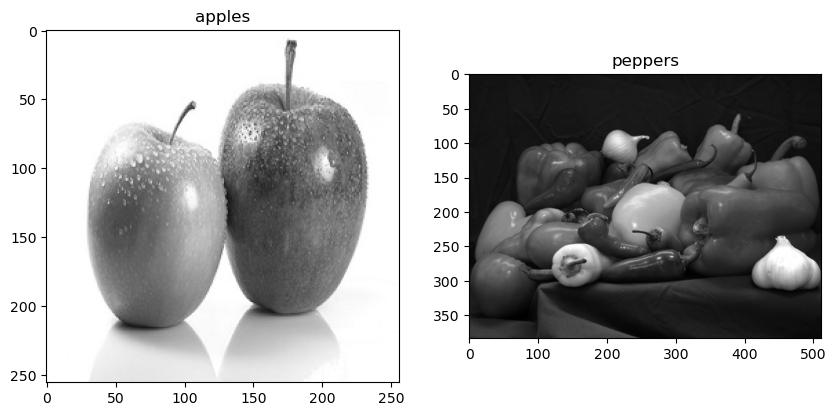

In [2]:
image1 = cv2.imread('apple.jpg') #loading apples image
image2 = cv2.imread('peppers.jpg') #loading peppers image

#convert the image from BGR to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) 
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

imshow_all(gray_image1, gray_image2, titles=['apples', 'peppers'])

# Region growing with Random seeding 

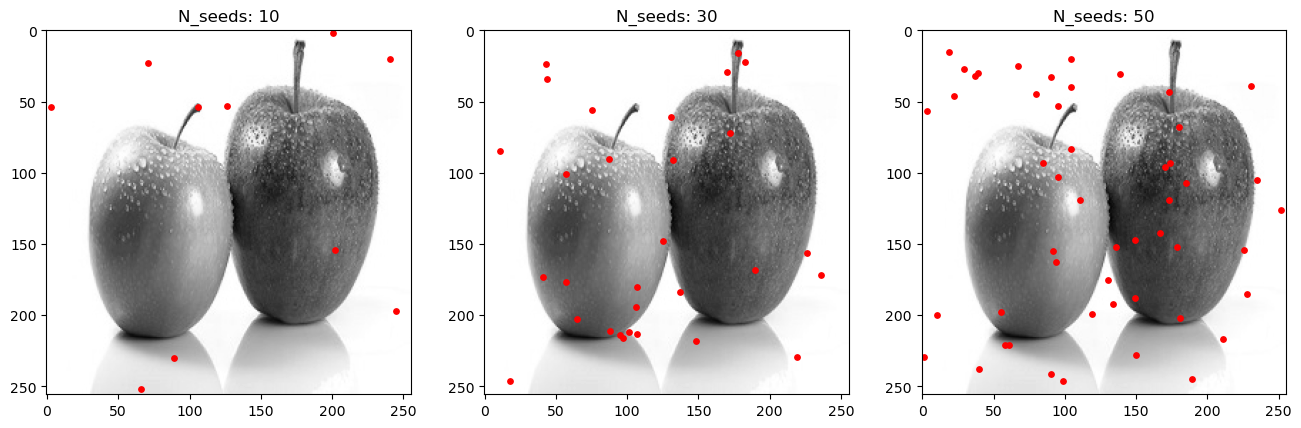

In [3]:
#generating patches of random seeds
rows, cols = gray_image1.shape
seeds = []
N_seed = []
for i in range(10,51,20):
    points = random.sample(range(0, rows * cols), i)
    seeds.append([(point // cols, point % cols) for point in points])
    N_seed.append('N_seeds: ' + str(i))

#visualize the generated random seeds
fig, axes = plt.subplots(nrows=1, ncols=len(seeds), figsize=(16,16))
for seed, i in zip(seeds, range(len(seeds))):   
    visualize_seeds = np.array(seed)
    axes[i].imshow(gray_image1, cmap='gray')
    axes[i].scatter(visualize_seeds[:, 1], visualize_seeds[:, 0], c='red', s=15)
    axes[i].set_title(N_seed[i])
plt.show()

## the 'region_growing' function takes the input image, a list of seed points, and the intensity difference threshold as inputs. It initializes a 'segmented_image' array with the same shape as the input image and sets all its values to zero.

## The algorithm then uses a while loop to grow the region from the seed points. The loop continues as long as there are seed points in the list. In each iteration, a seed point is popped from the list and its corresponding pixel in the segmented_image is set to the exact value of the original image.

## Next, the function iterates through the 4 neighboring pixels and calculates the intensity difference between the current seed pixel and its neighbors. If the intensity difference is less than the threshold and the neighboring pixel has not yet been added to the segmented image, the pixel is added to the seed list. The loop continues until all seed points have been processed and the 'segmented_image' is returned as the result.

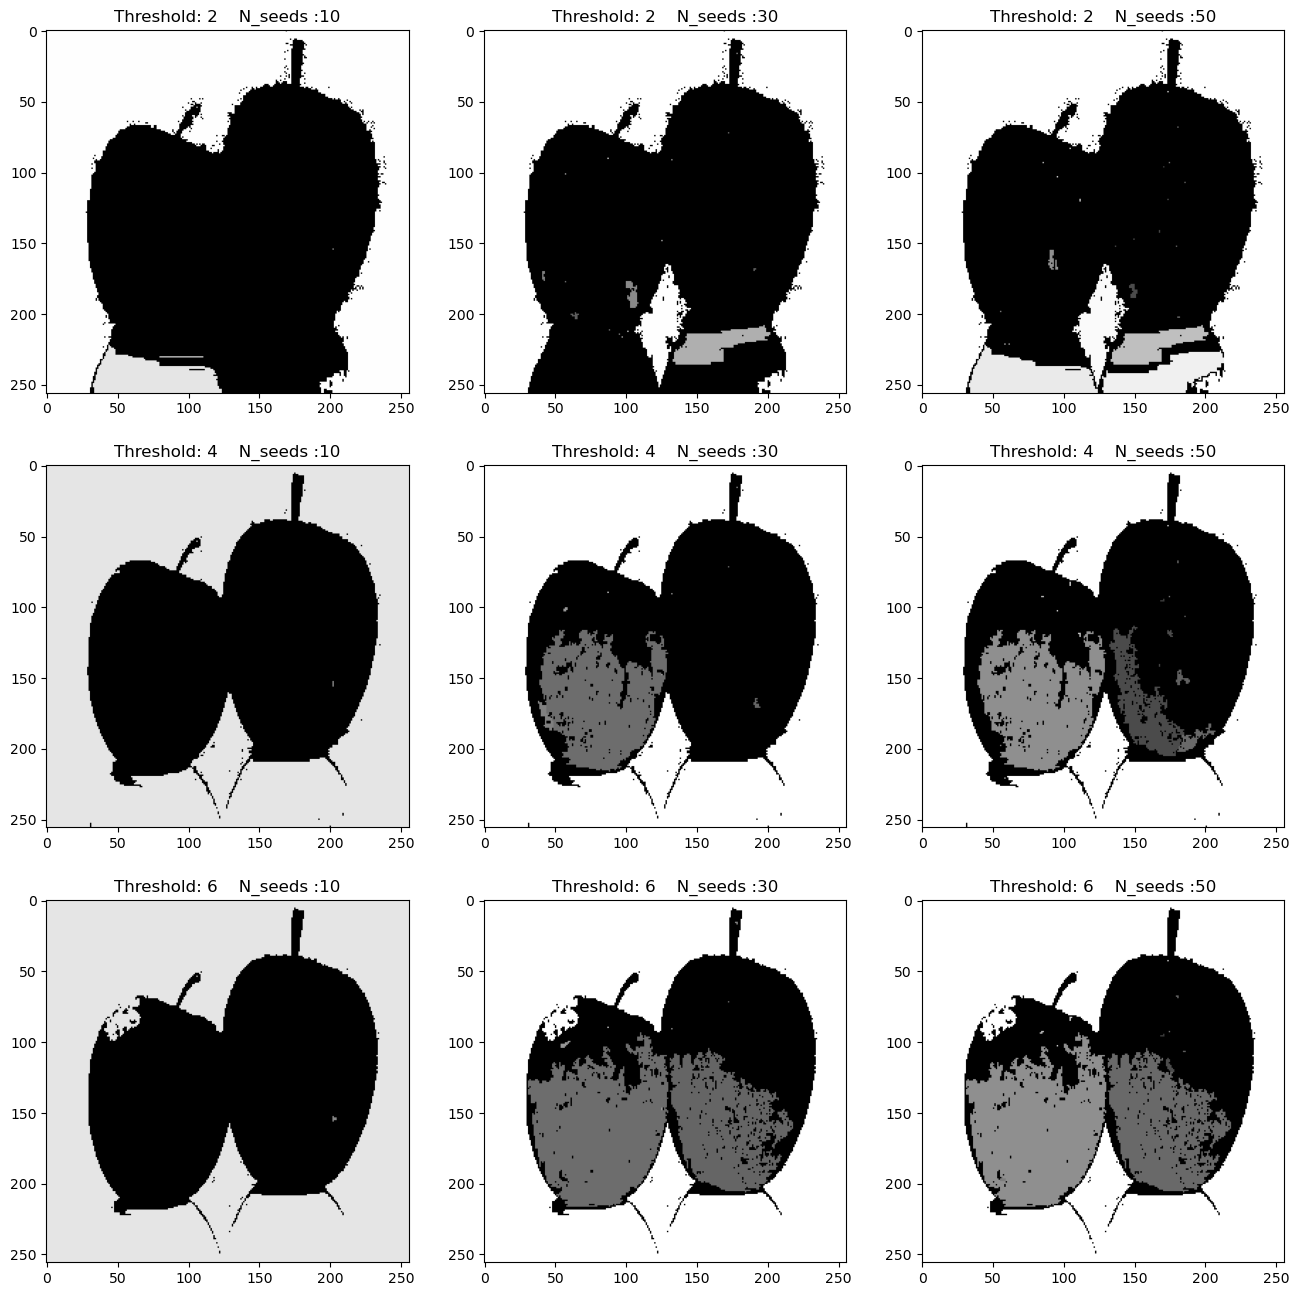

In [4]:
#selecting the intensity threshold for region growing
thresholds = [2 ,4, 6]

images = []
titles = []
for threshold in thresholds:
    for seed in seeds:
        images.append(region_growing(gray_image1,seed,threshold))
        titles.append('Threshold: ' + str(threshold) + '    N_seeds :' + str(len(seed)))
    
print_images(images, len(thresholds), len(seeds), titles)

# Random seeding: peppers

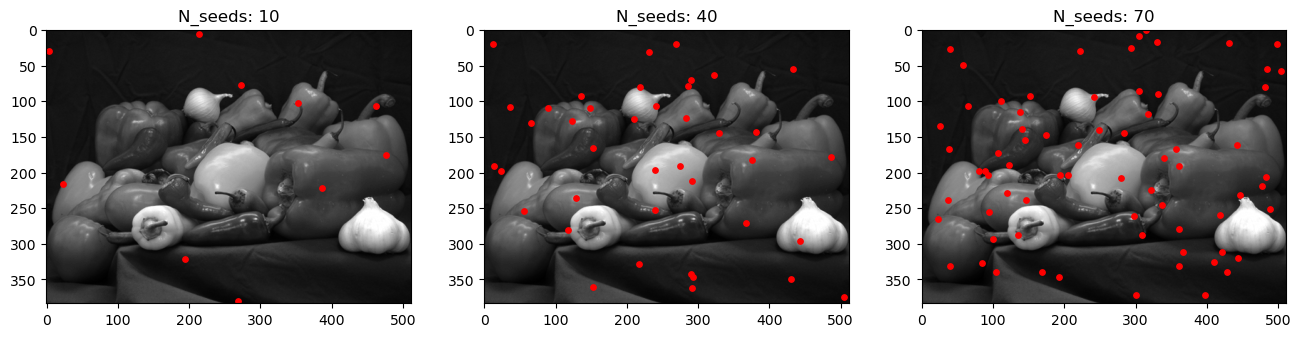

In [5]:
#generating patches of random seeds
rows, cols = gray_image2.shape
seeds = []
N_seed = []
for i in range(10,71,30):
    points = random.sample(range(0, rows * cols), i)
    seeds.append([(point // cols, point % cols) for point in points])
    N_seed.append('N_seeds: ' + str(i))

#visualize the generated random seeds
fig, axes = plt.subplots(nrows=1, ncols=len(seeds), figsize=(16,16))
for seed, i in zip(seeds, range(len(seeds))):   
    visualize_seeds = np.array(seed)
    axes[i].imshow(gray_image2, cmap='gray')
    axes[i].scatter(visualize_seeds[:, 1], visualize_seeds[:, 0], c='red', s=15)
    axes[i].set_title(N_seed[i])
plt.show()

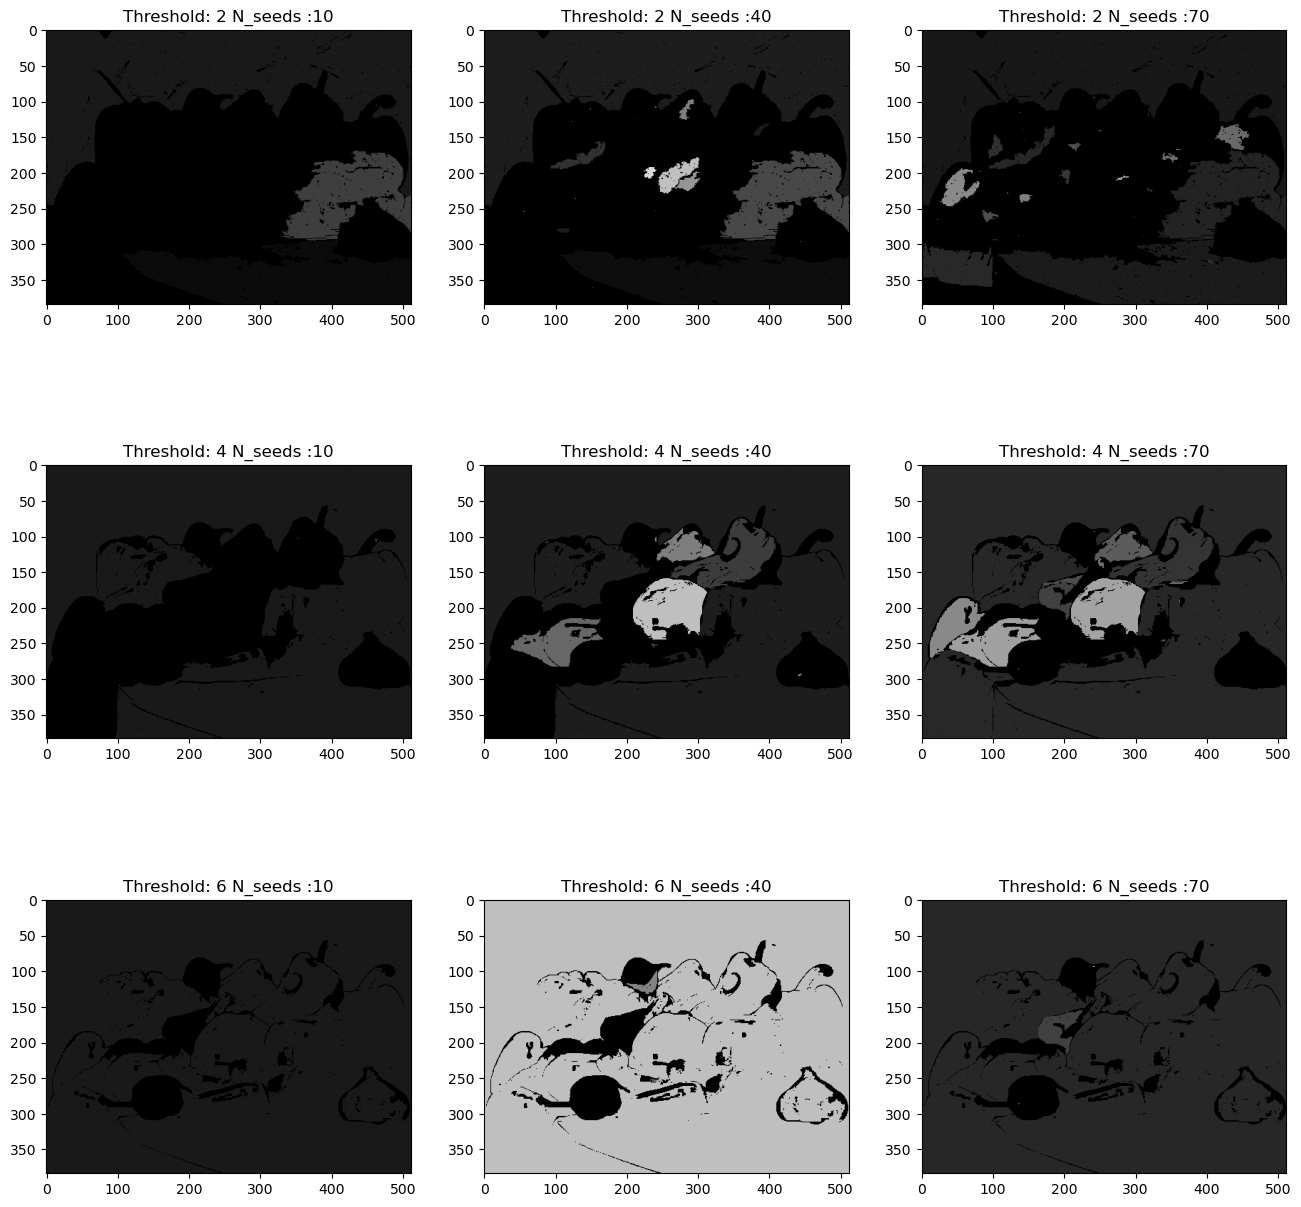

In [6]:
#selecting the intensity threshold for region growing
thresholds = [2 ,4, 6]

images = []
titles = []
for threshold in thresholds:
    for seed in seeds:
        images.append(region_growing(gray_image2,seed,threshold))
        titles.append('Threshold: ' + str(threshold) + ' N_seeds :' + str(len(seed)))
    
print_images(images, len(thresholds), len(seeds), titles)

# Region growing with gradient seeding

### cv2.Sobel is used to calculate the gradient in the x and y directions, and then the gradient magnitude is computed as the square root of the sum of squares of the gradient in the x and y directions.

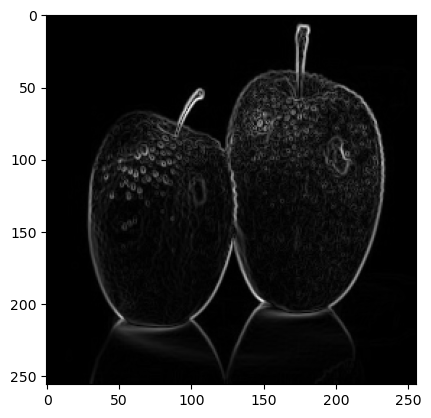

In [7]:
gradient = gradient_magnitude(gray_image1)
plt.imshow(gradient, cmap='gray')
plt.show()

### We create a binary edge map by setting all the pixels in the gradient magnitude image that are greater than or equal to the threshold to 255 and the rest to 0. The resulting binary edge map has edges represented by white pixels (255) and non-edges represented by black pixels (0).

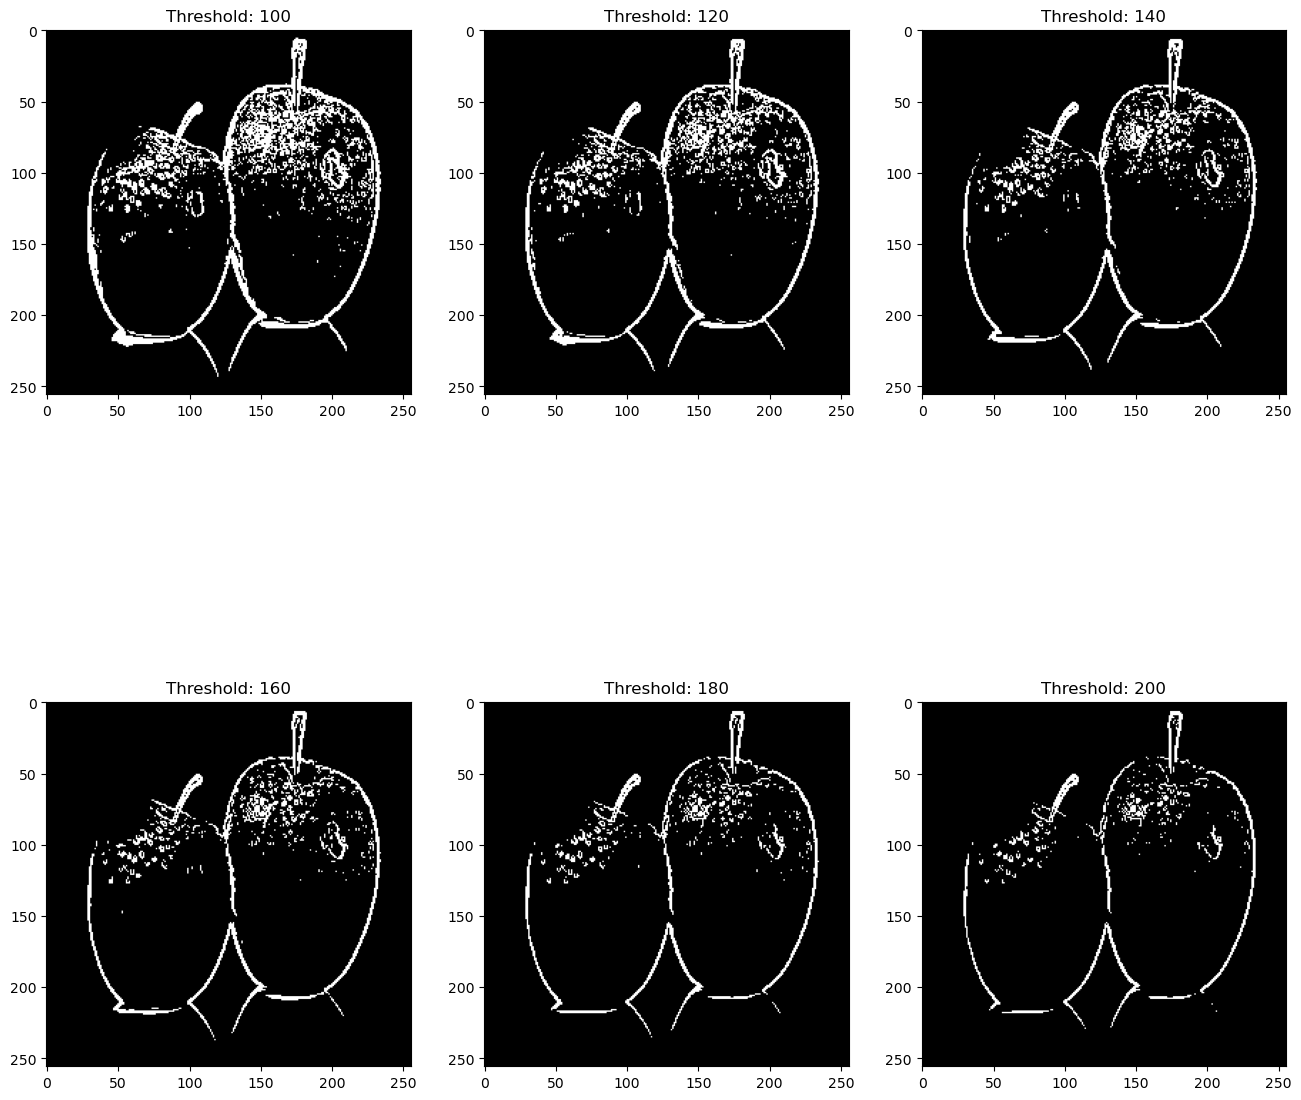

In [8]:
binary_maps = []
captions = []
for i in range(100,210,20):
    binary_maps.append(threshold_gradient_magnitude(gradient,i))
    captions.append('Threshold: ' + str(i));

print_images(binary_maps, 2, int(len(binary_maps) / 2), captions)

### whenever a white pixel is found a function is called to label the pixel and all the connected component that includes that pixel. The label variable is incremented each time a new connected component is found, so that each connected component has an unique label.

In [9]:
binary_image = threshold_gradient_magnitude(gradient,180)
labels = find_connected_components(binary_image)

### We calculate the centroids by iterating through each unique label and calculates the row and column sums of all the pixels that belong to that label. Finally, the centroid of each connected component is calculated by dividing the row and column sums by the number of pixels that belong to each connected component.

In [10]:
centroids = calculate_centroid(labels)

### In the end, we can obtain the centroids with low gradient magnitude by iterate through each centroid and checks the corresponding gradient magnitude value. If the gradient magnitude is less than a given threshold, the centroid is considered to be part of a connected component with low gradient magnitude, and its corresponding pixel is added to the list of selected seeds.

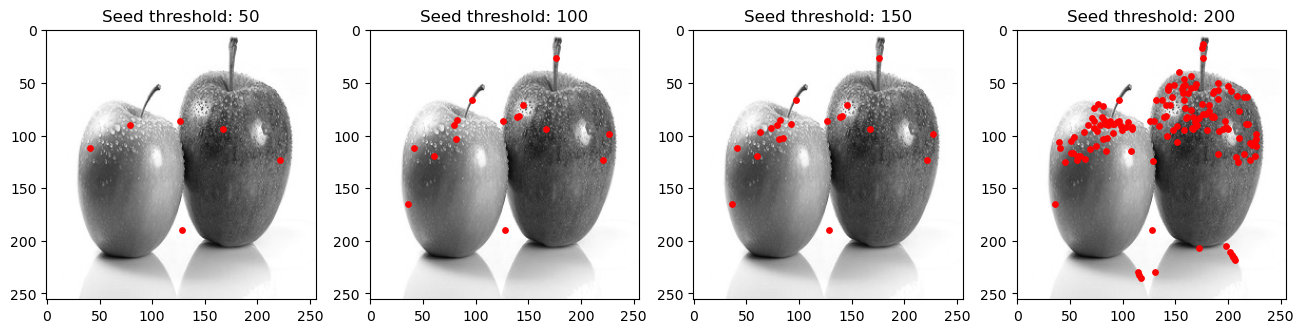

In [11]:
#generating patches of seeds based on gradient magnitude
rows, cols = gray_image1.shape
seeds = []
titles = []
thresholds = [50, 100, 150, 200]
for threshold in thresholds:
    seeds.append(select_components(centroids, gradient, threshold))
    titles.append('Seed threshold: ' + str(threshold))

#visualize the generated patches of seeds
fig, axes = plt.subplots(nrows=1, ncols=len(seeds), figsize=(16,16))
for seed, i in zip(seeds, range(len(seeds))):   
    visualize_seeds = np.array(seed)
    axes[i].imshow(gray_image1, cmap='gray')
    axes[i].scatter(visualize_seeds[:, 1], visualize_seeds[:, 0], c='red', s=15)
    axes[i].set_title(titles[i])
plt.show()

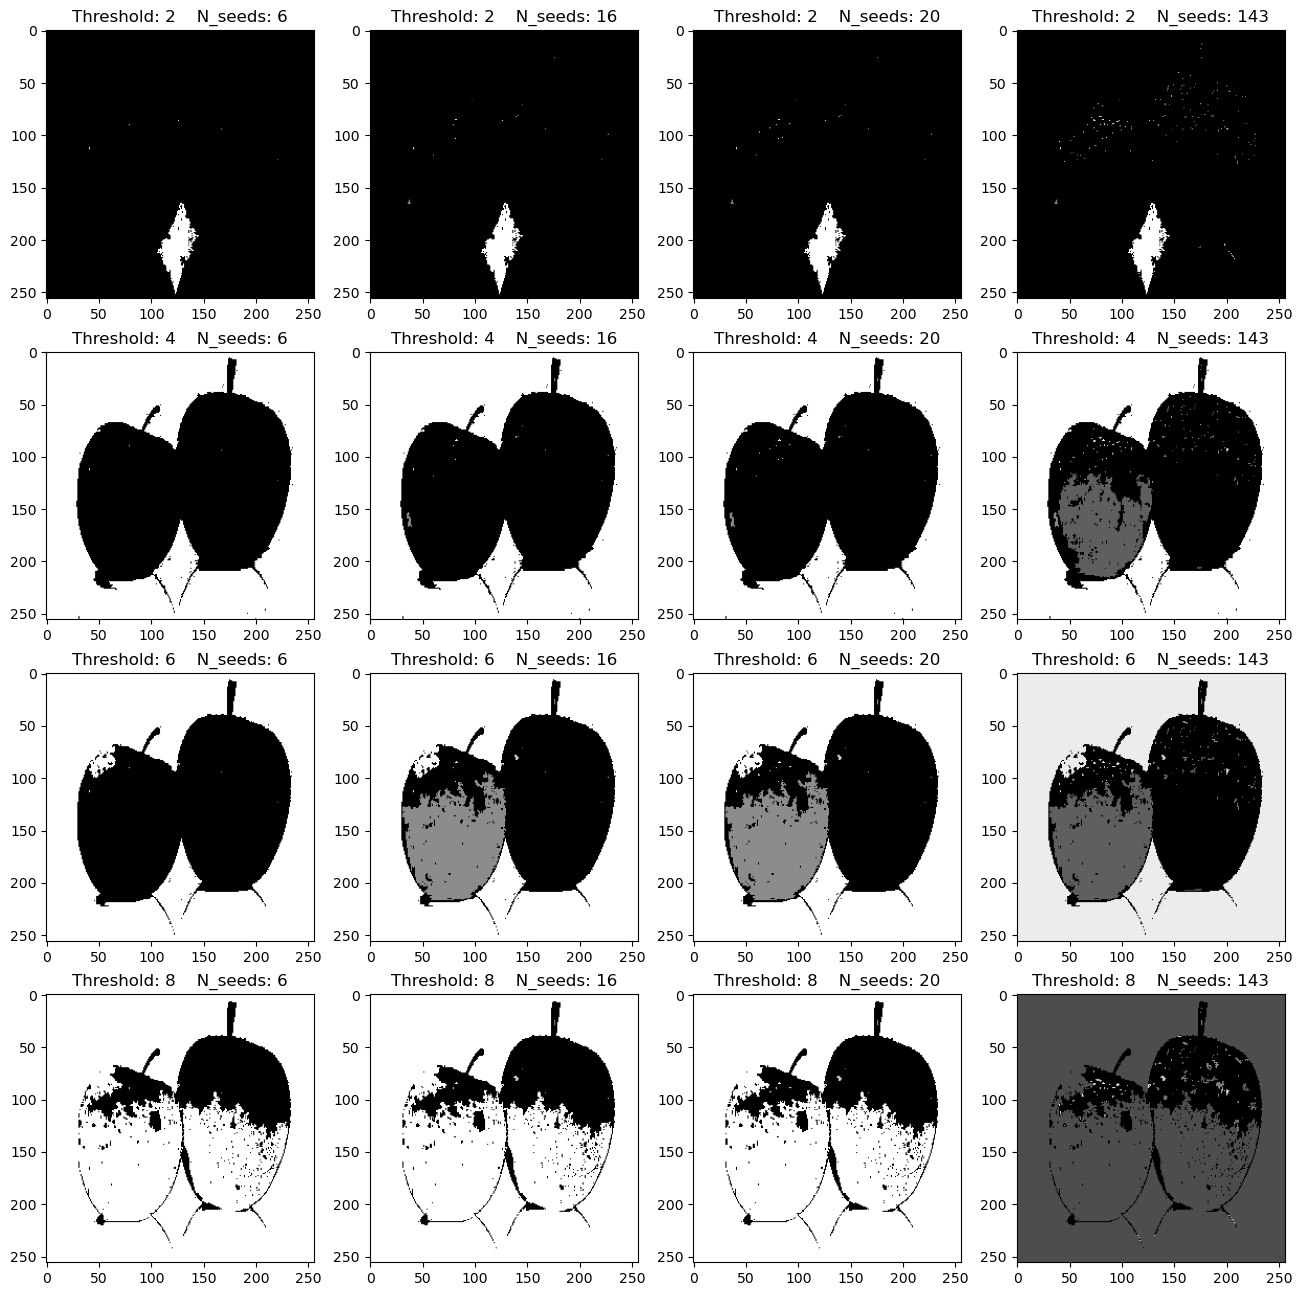

In [12]:
#selecting the intensity threshold for region growing
intensity_thresholds = [2 ,4, 6, 8]

images = []
titles = []
for threshold in intensity_thresholds:
    for seed in seeds:
        images.append(region_growing(gray_image1,seed,threshold))
        titles.append('Threshold: ' + str(threshold) + '    N_seeds: ' + str(len(seed)))
    
print_images(images, len(thresholds), len(seeds), titles)

# Gradient seeding: peppers

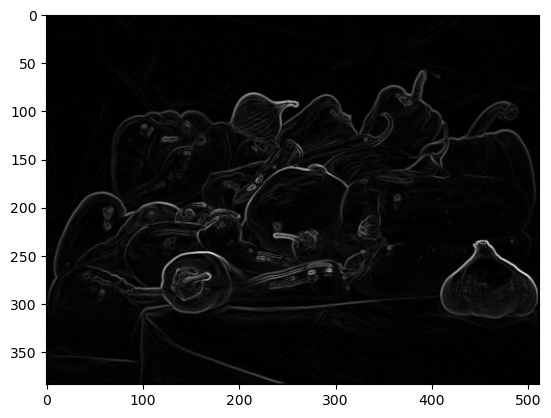

In [13]:
gradient = gradient_magnitude(gray_image2)
plt.imshow(gradient, cmap='gray')
plt.show()

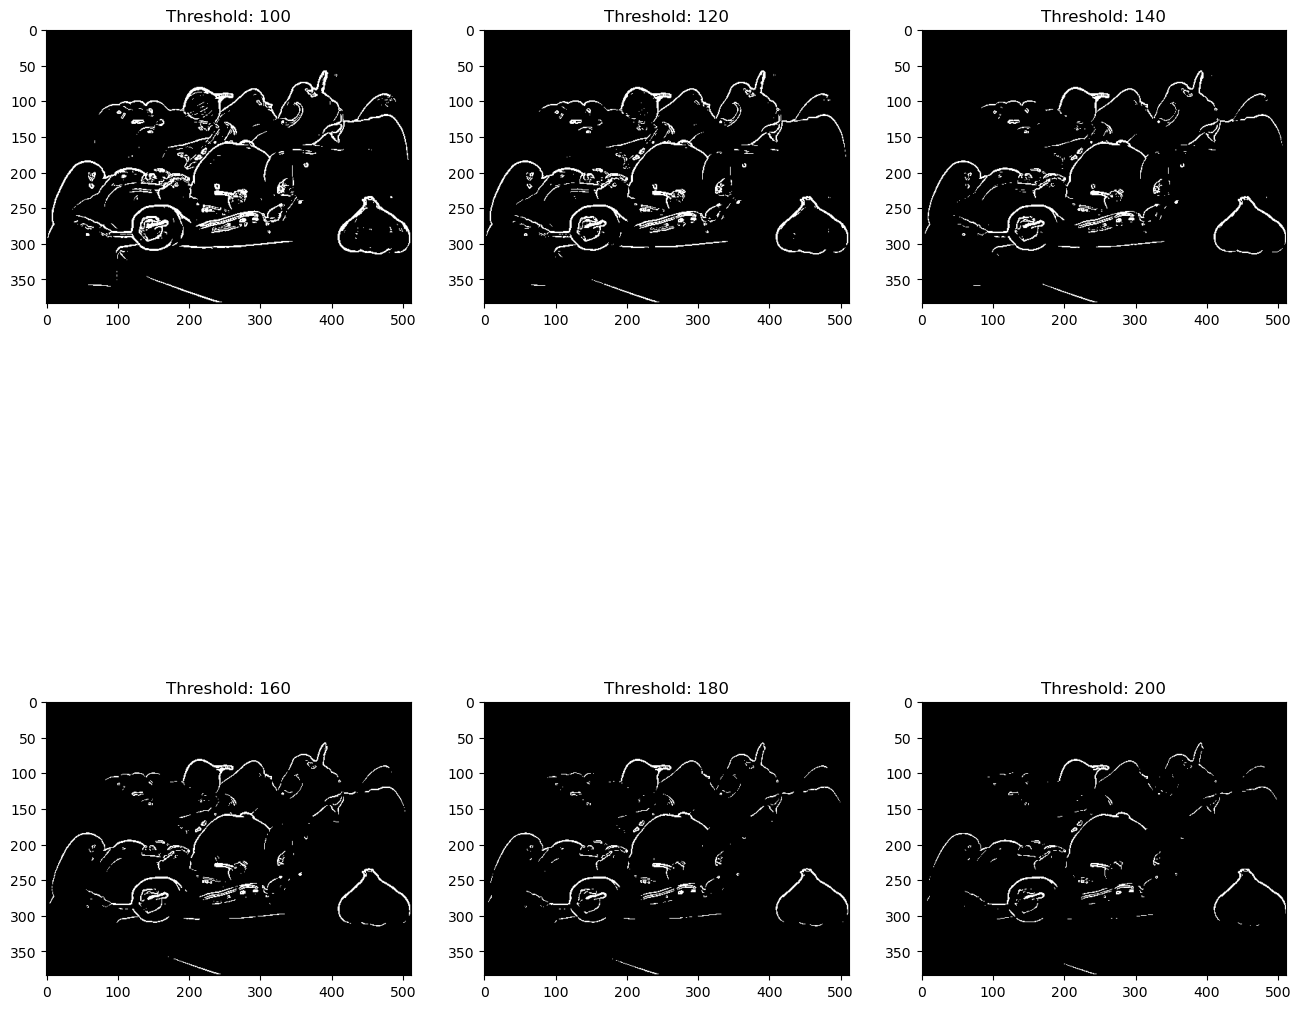

In [14]:
binary_maps = []
captions = []
for i in range(100,210,20):
    binary_maps.append(threshold_gradient_magnitude(gradient,i))
    captions.append('Threshold: ' + str(i));

print_images(binary_maps, 2, int(len(binary_maps) / 2), captions)

In [15]:
binary_image = threshold_gradient_magnitude(gradient,100)
labels = find_connected_components(binary_image)

In [16]:
centroids = calculate_centroid(labels)

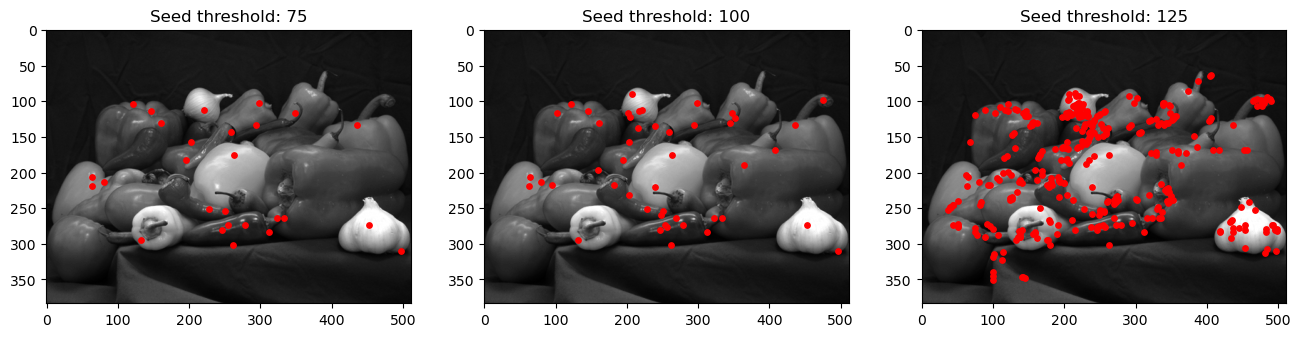

In [17]:
#generating patches of seeds based on gradient magnitude
rows, cols = gray_image2.shape
seeds = []
titles = []
thresholds = [75, 100, 125]
for threshold in thresholds:
    seeds.append(select_components(centroids, gradient, threshold))
    titles.append('Seed threshold: ' + str(threshold))

#visualize the generated patches of seeds
fig, axes = plt.subplots(nrows=1, ncols=len(seeds), figsize=(16,16))
for seed, i in zip(seeds, range(len(seeds))):   
    visualize_seeds = np.array(seed)
    axes[i].imshow(gray_image2, cmap='gray')
    axes[i].scatter(visualize_seeds[:, 1], visualize_seeds[:, 0], c='red', s=15)
    axes[i].set_title(titles[i])
plt.show()

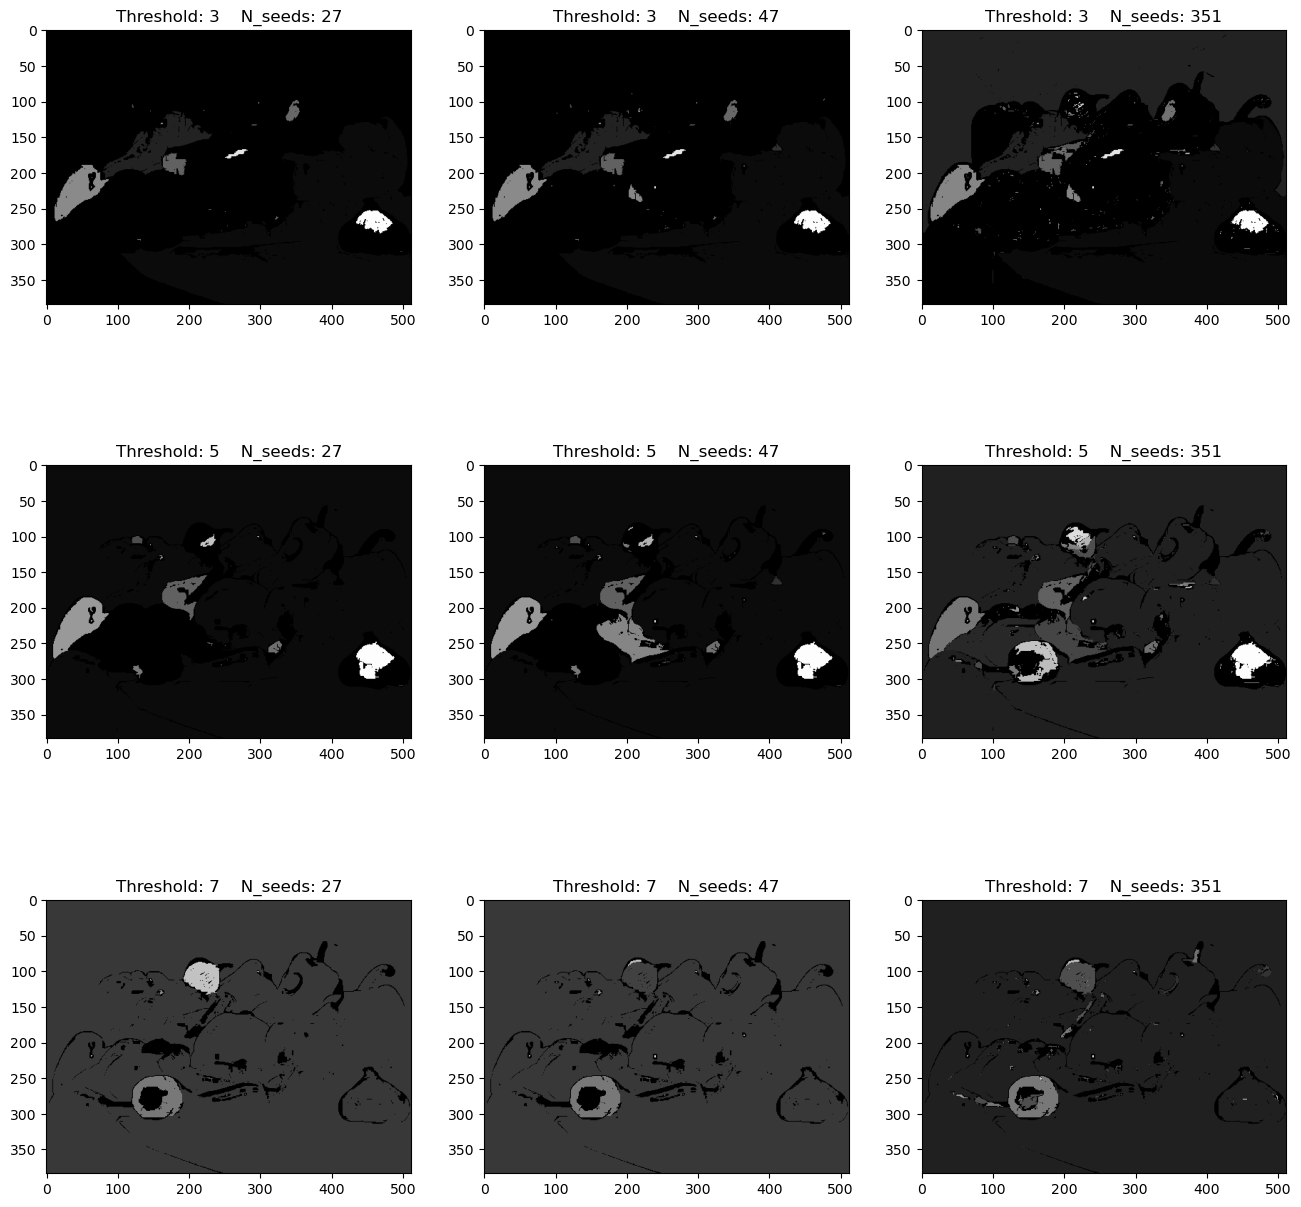

In [18]:
#selecting the intensity threshold for region growing
intensity_thresholds = [3, 5, 7]

images = []
titles = []
for threshold in intensity_thresholds:
    for seed in seeds:
        images.append(region_growing(gray_image2,seed,threshold))
        titles.append('Threshold: ' + str(threshold) + '    N_seeds: ' + str(len(seed)))
    
print_images(images, len(thresholds), len(seeds), titles)